# Clustering London Stations

Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Get Data

### London Stations

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.doogal.co.uk/london_stations.php'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

tbl = soup.find("table",class_='sortable stationsTable table table-striped table-hover')

london_data_all = pd.read_html(str(tbl))[0]

Check it looks okay

In [4]:
london_data = london_data_all.loc[london_data_all['Zone'] <3 ]
london_data.head()

Station  Zone  Postcode   Latitude  Longitude  Easting  Northing
2   Acton Central   2.0    W3 6BH  51.508758  -0.263430   520613    180299
8         Aldgate   1.0  EC3N 1AH  51.514342  -0.075627   533629    181246
9    Aldgate East   1.0    E1 7PT  51.515082  -0.073001   533809    181333
11     All Saints   2.0   E14 0EH  51.510477  -0.012625   538012    180933
16          Angel   1.0    N1 8XB  51.532968  -0.105581   531497    183263

In [5]:
london_data_all.describe()

Zone    Latitude   Longitude        Easting       Northing
count   643.000000  652.000000  652.000000     652.000000     652.000000
mean    176.595645   51.502543   -0.132826  529694.239264  179843.246933
std     751.107281    0.081910    0.160133   11119.401270    9105.421240
min       1.000000   51.282163   -0.971878  471527.000000  155422.000000
25%       2.000000   51.452608   -0.214120  524004.750000  174256.750000
50%       4.000000   51.509884   -0.119817  530618.000000  180774.500000
75%       5.000000   51.553922   -0.032569  536595.750000  185467.500000
max    3456.000000   51.747016    0.329952  561356.000000  207240.000000

In [6]:
latitude= 51.5074 
longitude= -0.1278
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Station, neighborhood in zip(london_data['Latitude'], london_data['Longitude'], london_data['Station'], london_data['Postcode']):
    label = '{}, {}'.format(neighborhood, Station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Visual inspection also shows stops line up with where they should be and can be seen on the train lines

### Foursquare Data

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

Check individual location to make sure its working

In [8]:
LIMIT = 500
#TQ345805,Wapping,Tower Hamlets,LONDON,E1,020,534500.0,180500.0,51.507432,-0.06336669
# create the API request URL
venues_list_t=[]
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    51.508976000000004,
    -0.33998438,
    500, 
    1000)

# make the GET request
results = requests.get(url).json()["response"]
#['groups'][0]["items"]
print(json.dumps(results,indent=4))
# return only relevant information for each nearby venue


{
    "suggestedFilters": {
        "header": "Tap to show:",
        "filters": [
            {
                "name": "Open now",
                "key": "openNow"
            }
        ]
    },
    "headerLocation": "Hanwell",
    "headerFullLocation": "Hanwell, London",
    "headerLocationGranularity": "neighborhood",
    "totalResults": 15,
    "suggestedBounds": {
        "ne": {
            "lat": 51.513476004500006,
            "lng": -0.3327677025745889
        },
        "sw": {
            "lat": 51.5044759955,
            "lng": -0.3472010574254111
        }
    },
    "groups": [
        {
            "type": "Recommended Places",
            "name": "recommended",
            "items": [
                {
                    "reasons": {
                        "count": 0,
                        "items": [
                            {
                                "summary": "This spot is popular",
                                "type": "general",
                    

Method to get all nearby venues based on longitude and latitude and return dataframe 'nearby_venues'

In [9]:
LIMIT = 1000
#london has too many venues in some locations if we use more than 300m radius
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        except KeyError:
            print(latitudes)
            #print latitiudes where we run into problems
        # return only relevant information for each nearby venue


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
        'Location Latitude', 
        'Location Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    
    return(nearby_venues)

#comment out below line if rerunning on same day, to avoid un-necessary calls to foursquare API
london_venues = getNearbyVenues(names=london_data['Station'], latitudes=london_data['Latitude'], longitudes=london_data['Longitude'] )

2      51.508758
8      51.514342
9      51.515082
11     51.510477
16     51.532968
21     51.558541
23     51.523130
25     51.513347
27     51.520215
33     51.490229
34     51.477318
35     51.479497
36     51.512111
47     51.550191
49     51.497961
51     51.527192
52     51.524283
57     51.511587
61     51.507832
62     51.513798
63     51.501049
66     51.527615
67     51.527042
73     51.462737
74     51.464750
78     51.545262
79     51.540325
87     51.547885
88     51.543285
89     51.532060
90     51.541851
91     51.539969
92     51.498168
93     51.503578
95     51.511362
96     51.548188
109    51.544149
110    51.518494
111    51.508359
127    51.513935
128    51.461804
129    51.465470
130    51.464367
131    51.464916
133    51.561569
141    51.512760
146    51.495840
151    51.481944
156    51.546094
157    51.548668
159    51.468201
160    51.478890
162    51.522258
165    51.553078
171    51.516263
173    51.461626
181    51.520645
182    51.519998
191    51.5073

Check that we didnt hit any limits on responses per location

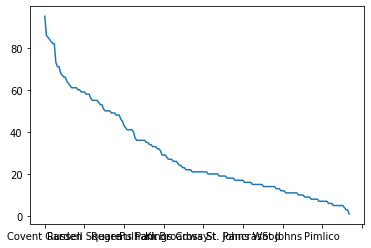

In [10]:
import random

x = london_venues['Location'].value_counts()
x1 =(x-min(x))/(max(x)-min(x))
x.plot()


In [11]:
london_venues.head()

Location  Location Latitude  Location Longitude              Venue  \
0  Acton Central          51.508758            -0.26343  The Station House   
1  Acton Central          51.508758            -0.26343         Acton Park   
2  Acton Central          51.508758            -0.26343         The Rocket   
3  Acton Central          51.508758            -0.26343      Laveli Bakery   
4  Acton Central          51.508758            -0.26343        Park+Bridge   

   Venue Latitude  Venue Longitude Venue Category  
0       51.508877        -0.263076            Pub  
1       51.508595        -0.261573           Park  
2       51.508772        -0.263787            Pub  
3       51.508859        -0.263366         Bakery  
4       51.508382        -0.267084      Wine Shop

In [12]:
#london_venues = get_csv(london_venues)

In [13]:
print(london_venues.head())
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

        Location  Location Latitude  Location Longitude              Venue  \
0  Acton Central          51.508758            -0.26343  The Station House   
1  Acton Central          51.508758            -0.26343         Acton Park   
2  Acton Central          51.508758            -0.26343         The Rocket   
3  Acton Central          51.508758            -0.26343      Laveli Bakery   
4  Acton Central          51.508758            -0.26343        Park+Bridge   

   Venue Latitude  Venue Longitude Venue Category  
0       51.508877        -0.263076            Pub  
1       51.508595        -0.261573           Park  
2       51.508772        -0.263787            Pub  
3       51.508859        -0.263366         Bakery  
4       51.508382        -0.267084      Wine Shop  
There are 338 uniques categories.


## Clustering v1

In [329]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="_", prefix_sep="")

# add neighborhood column back to front of dataframe
london_onehot.insert(0, 'Location', london_venues['Location'] )
london_onehot.head()

#First run and second run below, uncomment for each
london_grouped = london_onehot.groupby('Location').mean().reset_index()
#london_grouped = london_onehot.groupby('Location').sum().reset_index()

london_grouped.head()

Location  _ATM  _Accessories Store  _Adult Boutique  \
0  Acton Central   0.0                 0.0              0.0   
1        Aldgate   0.0                 0.0              0.0   
2   Aldgate East   0.0                 0.0              0.0   
3     All Saints   0.0                 0.0              0.0   
4          Angel   0.0                 0.0              0.0   

   _African Restaurant  _American Restaurant  _Animal Shelter  _Antique Shop  \
0             0.000000                  0.00              0.0            0.0   
1             0.000000                  0.02              0.0            0.0   
2             0.016393                  0.00              0.0            0.0   
3             0.000000                  0.00              0.0            0.0   
4             0.000000                  0.00              0.0            0.0   

   _Arepa Restaurant  _Argentinian Restaurant  _Art Gallery  _Art Museum  \
0                0.0                 0.000000      0.000000          0.0   
1                0.0                 0.020000      0.000000          0.0   
2                0.0                 0.016393      0.032787          0.0   
3                0.0                 0.000000      0.000000          0.0   
4                0.0                 0.000000      0.013699          0.0   

   _Arts & Crafts Store  _Arts & Entertainment  _Asian Restaurant  \
0              0.000000                    0.0           0.000000   
1              0.000000                    0.0           0.000000   
2              0.000000                    0.0           0.000000   
3              0.000000                    0.0           0.058824   
4              0.013699                    0.0           0.000000   

   _Athletics & Sports  _Australian Restaurant  _Austrian Restaurant  \
0                  0.0                     0.0              0.000000   
1                  0.0                     0.0              0.000000   
2                  0.0                     0.0              0.000000   
3                  0.0                     0.0              0.000000   
4                  0.0                     0.0              0.013699   

   _Auto Garage  _BBQ Joint  _Baby Store  _Badminton Court  _Bagel Shop  \
0           0.0    0.000000          0.0               0.0          0.0   
1           0.0    0.000000          0.0               0.0          0.0   
2           0.0    0.016393          0.0               0.0          0.0   
3           0.0    0.000000          0.0               0.0          0.0   
4           0.0    0.000000          0.0               0.0          0.0   

    _Bakery      _Bar  _Bed & Breakfast  _Beer Bar  _Beer Garden  _Beer Store  \
0  0.125000  0.000000               0.0       0.00           0.0          0.0   
1  0.020000  0.000000               0.0       0.02           0.0          0.0   
2  0.016393  0.016393               0.0       0.00           0.0          0.0   
3  0.058824  0.000000               0.0       0.00           0.0          0.0   
4  0.000000  0.000000               0.0       0.00           0.0          0.0   

   _Bike Rental / Bike Share  _Bike Shop  _Bistro  _Boarding House  \
0                        0.0         0.0      0.0              0.0   
1                        0.0         0.0      0.0              0.0   
2                        0.0         0.0      0.0              0.0   
3                        0.0         0.0      0.0              0.0   
4                        0.0         0.0      0.0              0.0   

   _Boat or Ferry  _Bookstore  _Boutique  _Bowling Alley  _Boxing Gym  \
0             0.0    0.000000   0.000000             0.0          0.0   
1             0.0    0.000000   0.000000             0.0          0.0   
2             0.0    0.000000   0.000000             0.0          0.0   
3             0.0    0.000000   0.000000             0.0          0.0   
4             0.0    0.013699   0.013699             0.0          0.0   

   _Brasserie  _Brazilian Restaurant  _Breakf

Method to return most common venues

In [330]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]



num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location'] = london_grouped['Location']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

Location  1st Most Common Venue 2nd Most Common Venue  \
0             Acton Central                   _Pub        _Grocery Store   
1                   Aldgate           _Coffee Shop                _Hotel   
2              Aldgate East           _Coffee Shop                  _Pub   
3                All Saints         _Grocery Store          _Pizza Place   
4                     Angel           _Coffee Shop                  _Pub   
5                   Arsenal  _Gym / Fitness Center                 _Park   
6              Baker Street           _Coffee Shop         _Burger Joint   
7                  Barbican  _Gym / Fitness Center             _Wine Bar   
8              Barons Court              _Platform                 _Café   
9            Battersea Park                   _Bar                  _Pub   
10  Battersea Power Station                   _Bar                  _Pub   
11                Bayswater                 _Hotel   _Chinese Restaurant   
12             Belsize Park           _Pizza Place                _Hotel   
13               Bermondsey         _Grocery Store          _Coffee Shop   
14            Bethnal Green           _Coffee Shop          _Pizza Place   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0               _Wine Shop                 _Park            _Mini Golf   
1                     _Pub    _Indian Restaurant         _Cocktail Bar   
2                   _Hotel                 _Café         _Cocktail Bar   
3                   _Hotel               _Bakery                 _Café   
4                    _Café                _Hotel        _Burrito Place   
5       _Fish & Chips Shop       _Clothing Store        _Metro Station   
6        _Sushi Restaurant       _Sandwich Place               _Museum   
7             _Art Gallery  _Indie Movie Theater       _Scenic Lookout   
8           _Indie Theater                  _Pub                _Hotel   
9      _Chinese Restaurant   _Spanish Restaurant  _Fried Chicken Joint   
10         _Animal Shelter             _Bus Stop      _Warehouse Store   
11            _Coffee Shop                  _Pub               _Hostel   
12      _Convenience Store               _Bakery          _Coffee Shop   
13  _Indonesian Restaurant                  _Pub       _Ice Cream Shop   
14           _Cocktail Bar                 _Café                  _Pub   

    6th Most Common Venue 7th Most Common Venue         8th Most Common Venue  \
0          _Train Station               _Bakery                      _Exhibit   
1   _Gym / Fitness Center       _Sandwich Place             _Sushi Restaurant   
2       _Sushi Restaurant   _Italian Restaurant               _Sandwich Place   
3                 _Market                 _Park                   _Steakhouse   
4             _Food Truck          _Supermarket                 _Burger Joint   
5         _History Museum               _Bakery                   _Sports Bar   
6                   _Café        _Movie Theater                  _Pizza Place   
7               _Beer Bar    _French Restaurant                       _Museum   
8                    _Gym       _Farmers Market  _Eastern European Restaurant   
9         _Animal Shelter   _Italian Restaurant        _Vietnamese Restaurant   
10           _Film Studio    _Electronics Store           _English Restaurant   
11        _Sandwich Place     _Malay Restaurant                     _Pharmacy   
12                  _Hill         _Burger Joint                _Movie Theater   
13   _Fried Chicken Joint  _Dumpling Restaurant  _Eastern European Restaurant   
14            _Restaurant             _Beer Bar         _Gym / Fitness Center   

    9th Most Common Venue        10th Most Common Venue  
0    _Dumpling Restaurant  _Eastern European Restaurant  
1        _Thai Restaurant             _Greek Restaurant  
2   _Gym / Fitness Center              _Thai Restaurant  
3       _Asian Restaurant                     _Pharmacy  
4              _Nightclub     

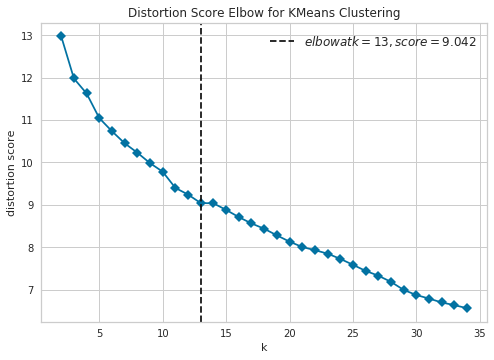

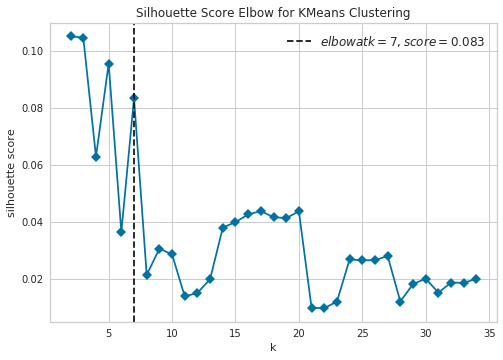

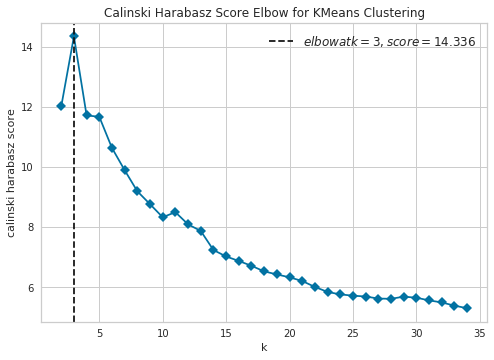

In [388]:
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.datasets.loaders import load_nfl

london_grouped_clustering = london_grouped.drop('Location', 1)
model = KMeans(random_state=0)
# Use the quick method and immediately show the figure
v = KElbowVisualizer(model, k=(2,35),metric="distortion",timings=False)
v.fit(london_grouped_clustering)
v.show()
v1 = KElbowVisualizer(model, k=(2,35),metric="silhouette",timings=False)
v1.fit(london_grouped_clustering)
v1.show()
v2 = KElbowVisualizer(model, k=(2,35),metric="calinski_harabasz",timings=False)
v2.fit(london_grouped_clustering)
v2.show()

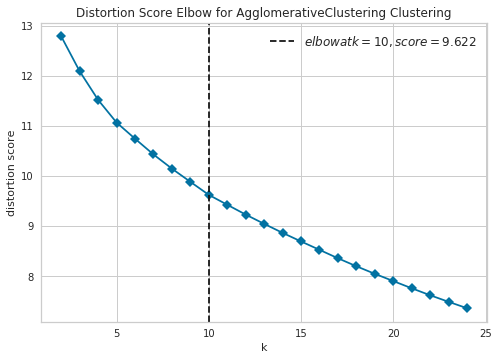

/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


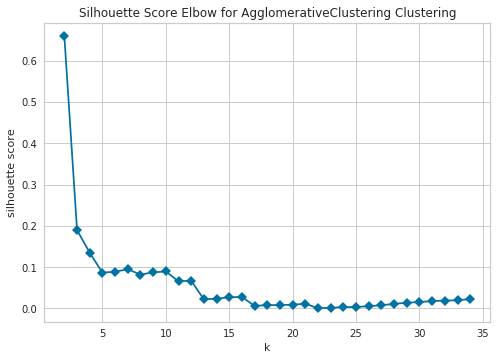

/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


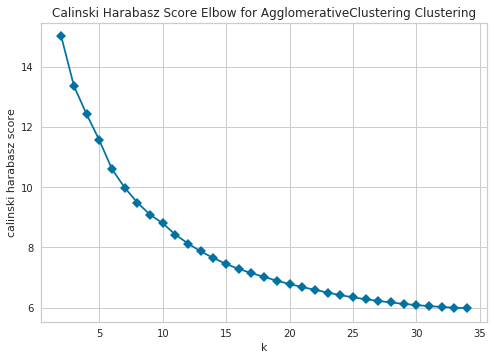

In [332]:
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.datasets.loaders import load_nfl

london_grouped_clustering = london_grouped.drop('Location', 1)
model = AgglomerativeClustering()
# Use the quick method and immediately show the figure
v = KElbowVisualizer(model, k=(2,25),metric="distortion",timings=False)
v.fit(london_grouped_clustering)
v.show()
v1 = KElbowVisualizer(model, k=(2,35),metric="silhouette",timings=False)
v1.fit(london_grouped_clustering)
v1.show()
v2 = KElbowVisualizer(model, k=(2,35),metric="calinski_harabasz",timings=False)
v2.fit(london_grouped_clustering)
v2.show()

In [16]:
london_grouped.head()

Location  _ATM  _Accessories Store  _Adult Boutique  \
0  Acton Central     0                   0                0   
1        Aldgate     0                   0                0   
2   Aldgate East     0                   0                0   
3     All Saints     0                   0                0   
4          Angel     0                   0                0   

   _African Restaurant  _American Restaurant  _Animal Shelter  _Antique Shop  \
0                    0                     0                0              0   
1                    0                     1                0              0   
2                    1                     0                0              0   
3                    0                     0                0              0   
4                    0                     0                0              0   

   _Arepa Restaurant  _Argentinian Restaurant  _Art Gallery  _Art Museum  \
0                  0                        0             0            0   
1                  0                        1             0            0   
2                  0                        1             2            0   
3                  0                        0             0            0   
4                  0                        0             1            0   

   _Arts & Crafts Store  _Arts & Entertainment  _Asian Restaurant  \
0                     0                      0                  0   
1                     0                      0                  0   
2                     0                      0                  0   
3                     0                      0                  1   
4                     1                      0                  0   

   _Athletics & Sports  _Australian Restaurant  _Austrian Restaurant  \
0                    0                       0                     0   
1                    0                       0                     0   
2                    0                       0                     0   
3                    0                       0                     0   
4                    0                       0                     1   

   _Auto Garage  _BBQ Joint  _Baby Store  _Badminton Court  _Bagel Shop  \
0             0           0            0                 0            0   
1             0           0            0                 0            0   
2             0           1            0                 0            0   
3             0           0            0                 0            0   
4             0           0            0                 0            0   

   _Bakery  _Bar  _Bed & Breakfast  _Beer Bar  _Beer Garden  _Beer Store  \
0        1     0                 0          0             0            0   
1        1     0                 0          1             0            0   
2        1     1                 0          0             0            0   
3        1     0                 0          0             0            0   
4        0     0                 0          0             0            0   

   _Bike Rental / Bike Share  _Bike Shop  _Bistro  _Boarding House  \
0                          0           0        0                0   
1                          0           0        0                0   
2                          0           0        0                0   
3                          0           0        0                0   
4                          0           0        0                0   

   _Boat or Ferry  _Bookstore  _Boutique  _Bowling Alley  _Boxing Gym  \
0               0           0          0               0            0   
1               0           0          0               0            0   
2               0           0          0               0            0   
3               0           0          0               0            0   
4               0           1          1               0            0   

   _Brasserie  _Brazilian Restaurant  _Breakfast Spot  _Brewery  _Bridge  \

In [327]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(london_grouped.drop('Location', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 6, 6, 1, 6, 1, 6, 1, 5, 4], dtype=int32)

In [333]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_data

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.merge(right=neighborhoods_venues_sorted,how="left",right_on='Location', left_on='Station')

london_merged.head() # check the last columns!

Station  Zone  Postcode   Latitude  Longitude  Easting  Northing  \
0  Acton Central   2.0    W3 6BH  51.508758  -0.263430   520613    180299   
1        Aldgate   1.0  EC3N 1AH  51.514342  -0.075627   533629    181246   
2   Aldgate East   1.0    E1 7PT  51.515082  -0.073001   533809    181333   
3     All Saints   2.0   E14 0EH  51.510477  -0.012625   538012    180933   
4          Angel   1.0    N1 8XB  51.532968  -0.105581   531497    183263   

   Cluster Labels       Location 1st Most Common Venue 2nd Most Common Venue  \
0             3.0  Acton Central                  _Pub        _Grocery Store   
1             6.0        Aldgate          _Coffee Shop                _Hotel   
2             6.0   Aldgate East          _Coffee Shop                  _Pub   
3             1.0     All Saints        _Grocery Store          _Pizza Place   
4             6.0          Angel          _Coffee Shop                  _Pub   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            _Wine Shop                 _Park            _Mini Golf   
1                  _Pub    _Indian Restaurant         _Cocktail Bar   
2                _Hotel                 _Café         _Cocktail Bar   
3                _Hotel               _Bakery                 _Café   
4                 _Café                _Hotel        _Burrito Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         _Train Station               _Bakery              _Exhibit   
1  _Gym / Fitness Center       _Sandwich Place     _Sushi Restaurant   
2      _Sushi Restaurant   _Italian Restaurant       _Sandwich Place   
3                _Market                 _Park           _Steakhouse   
4            _Food Truck          _Supermarket         _Burger Joint   

   9th Most Common Venue        10th Most Common Venue  
0   _Dumpling Restaurant  _Eastern European Restaurant  
1       _Thai Restaurant             _Greek Restaurant  
2  _Gym / Fitness Center              _Thai Restaurant  
3      _Asian Restaurant                     _Pharmacy  
4             _Nightclub                     _Pharmacy

In [389]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
london_merged.dropna(subset=['Cluster Labels'],inplace=True)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Station'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=300,
        popup=label,
        color=rainbow[int(cluster)-1] ,
        fill=True,
        fill_color= rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [390]:
london_merged.loc[london_merged['Cluster Labels'] == 1]


Station  Zone  Postcode   Latitude  Longitude  \
3                       All Saints   2.0   E14 0EH  51.510477  -0.012625   
5                          Arsenal   2.0    N5 1LP  51.558541  -0.105500   
8                         Barbican   1.0  EC1A 4JA  51.520215  -0.097722   
12                       Bayswater   1.0    W2 4QH  51.512111  -0.187902   
13                    Belsize Park   2.0   NW3 2AL  51.550191  -0.163974   
19                     Bond Street   1.0   W1C 2HU  51.513798  -0.149614   
23                         Brixton   2.0   SW9 8HE  51.462737  -0.114552   
26                Brondesbury Park   2.0   NW6 6RP  51.540325  -0.210474   
31                     Camden Town   2.0   NW1 8NH  51.539969  -0.142452   
38                   Charing Cross   1.0  WC2N 5HS  51.508359  -0.124803   
40                  Clapham Common   2.0   SW4 7AJ  51.461804  -0.138315   
45                   Covent Garden   1.0  WC2E 9JT  51.512760  -0.124507   
46   Crossharbour and London Arena   2.0   E14 8AD  51.495840  -0.014933   
49               Dalston Kingsland   2.0    E8 2JS  51.548668  -0.076227   
56         Edgware Road (Bakerloo)   1.0    W2 1DY  51.520645  -0.170540   
58                      Embankment   1.0  WC2N 6NS  51.507312  -0.122367   
62                      Farringdon   1.0  EC1M 6BY  51.520196  -0.104843   
73                      Green Park   1.0   W1J 7BX  51.506760  -0.142478   
77                      Haggerston   2.0    E8 4DY  51.538685  -0.075595   
81                     Heron Quays   2.0   E14 4JH  51.503387  -0.021954   
82          High Street Kensington   1.0    W8 5SA  51.500729  -0.191566   
88                Hyde Park Corner   1.0  SW1X 7LY  51.502584  -0.152474   
89                  Imperial Wharf   2.0   SW6 2HA  51.474939  -0.182838   
94            Kensington (Olympia)   2.0   W14 0NE  51.497880  -0.210379   
100                   King's Cross   1.0    N1 9AL  51.530798  -0.122756   
101        Kings Cross St. Pancras   1.0    N1 9AL  51.530312  -0.123872   
102                  Knightsbridge   1.0   SW3 1ED  51.501355  -0.160664   
108               Leicester Square   1.0  WC2H 0AP  51.511291  -0.128242   
110               Liverpool Street   1.0  EC2M 7PR  51.517598  -0.082250   
112                  London Fields   2.0    E8 3PH  51.540719  -0.057700   
115                  Mansion House   1.0  EC4N 6JD  51.512092  -0.094198   
119                       Monument   1.0  EC4R 9AA  51.510630  -0.086188   
122                       Mudchute   2.0   E14 9UW  51.491236  -0.014960   
129                  Oxford Circus   1.0   W1C 2JS  51.515223  -0.140836   
132                    Peckham Rye   2.0  SE15 5DQ  51.469511  -0.069984   
133              Piccadilly Circus   1.0   W1J 9HS  51.509697  -0.133712   
135                         Poplar   2.0   E14 0DS  51.507588  -0.017275   
140                      Queensway   1.0    W2 4SS  51.510449  -0.187420   
145                      Royal Oak   2.0    W2 6ET  51.518294  -0.188824   
148                 Shepherds Bush   2.0   W12 8LH  51.504532  -0.218519   
149          Shepherds Bush Market   2.0   W12 7JD  51.505881  -0.227400   
150         Shoreditch High Street   1.0    E1 6AW  51.523467  -0.077087   
151                  Sloane Square   1.0  SW1W 8BB  51.492360  -0.156489   
154               South Kensington   1.0   SW7 2NB  51.494071  -0.173923   
158                     St Pancras   1.0   NW1 2QP  51.530554  -0.125506   
161                      St. Pauls   1.0  EC2V 6AA  51.514835  -0.097571   
169           Tottenham Court Road   1.0   W1D 2DA  51.516211  -0.131110   
186                West India Quay   2.0   E14 4ED  51.506763  -0.020582   
189                      Westferry   2.0   E14 8AD  51.509638  -0.026323   
193                      Wood Lane   2.0   W12 7DS  51.509658  -0.224473   

     Easting  Northing  Cluster Labels                       Location  \
3     538012    180933             1.0                     All Saints   
5   

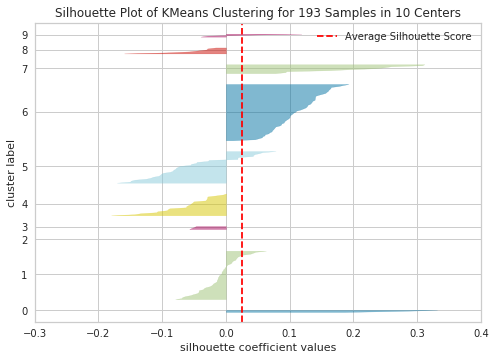

/home/law/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e2555f190>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [336]:
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.datasets import load_credit

# Load a clustering dataset
X, y = load_credit()
silhouette_visualizer(KMeans(10, random_state=42), london_grouped.drop('Location', 1), colors='yellowbrick')



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


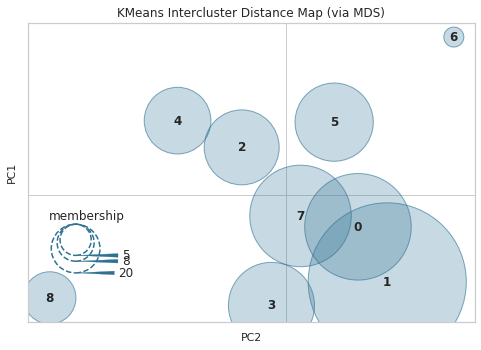

/home/law/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e405fec10>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

In [23]:
from yellowbrick.datasets import load_nfl
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import intercluster_distance


X, _ = load_nfl()
intercluster_distance(KMeans(9, random_state=777), london_grouped.drop('Location', 1))

### Tuning the System

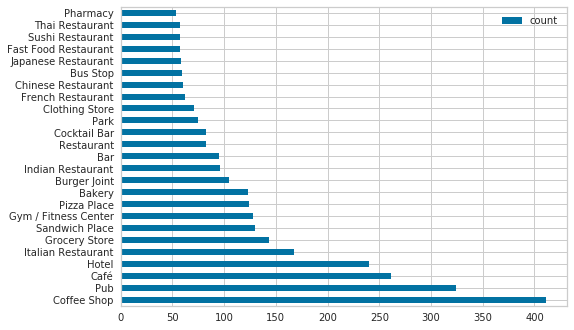

In [24]:
import matplotlib.pyplot as plt

venue_cat = london_venues.groupby("Venue Category")["Venue"].count()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
venue_cat.head(100)
ax = venue_cat[0:25].plot(kind="barh",yticks=venue_cat[0:20].index)
ax.set_yticklabels(venue_cat[0:25]["Venue Category"]);

In [25]:
london_venues.describe()

Location Latitude  Location Longitude  Venue Latitude  Venue Longitude
count        5726.000000         5726.000000     5726.000000      5726.000000
mean           51.512660           -0.125497       51.512689        -0.125425
std             0.023162            0.057880        0.023243         0.058062
min            51.461034           -0.263430       51.459754        -0.267084
25%            51.501049           -0.170315       51.500718        -0.170305
50%            51.512760           -0.128242       51.513270        -0.127541
75%            51.525311           -0.086006       51.525470        -0.084083
max            51.564638           -0.007235       51.566971        -0.004386

In [26]:
london_venues.head()

Location  Location Latitude  Location Longitude              Venue  \
0  Acton Central          51.508758            -0.26343  The Station House   
1  Acton Central          51.508758            -0.26343         Acton Park   
2  Acton Central          51.508758            -0.26343         The Rocket   
3  Acton Central          51.508758            -0.26343      Laveli Bakery   
4  Acton Central          51.508758            -0.26343        Park+Bridge   

   Venue Latitude  Venue Longitude Venue Category  
0       51.508877        -0.263076            Pub  
1       51.508595        -0.261573           Park  
2       51.508772        -0.263787            Pub  
3       51.508859        -0.263366         Bakery  
4       51.508382        -0.267084      Wine Shop

Elbow method suggests that we take a clustering size of 14, lets compare the silhoutte score of this to the 

Neither looks particularly good from the silhoutte scores, and cluster found by non elbow method was actually better

In [27]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION 
)

cat_list = []
results = requests.get(url).json()['response']['categories']
#[0]['categories']
print(json.dumps(results,indent=4))
#results.keys()

[
    {
        "id": "4d4b7104d754a06370d81259",
        "name": "Arts & Entertainment",
        "pluralName": "Arts & Entertainment",
        "shortName": "Arts & Entertainment",
        "icon": {
            "prefix": "https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_",
            "suffix": ".png"
        },
        "categories": [
            {
                "id": "56aa371be4b08b9a8d5734db",
                "name": "Amphitheater",
                "pluralName": "Amphitheaters",
                "shortName": "Amphitheater",
                "icon": {
                    "prefix": "https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_",
                    "suffix": ".png"
                },
                "categories": []
            },
            {
                "id": "4fceea171983d5d06c3e9823",
                "name": "Aquarium",
                "pluralName": "Aquariums",
                "shortName": "Aquarium",
                "icon": {
         

In [28]:
cat_list = []
#results = requests.get(url).json()['response']['categories']
from pandas import json_normalize

cat_df_1 = json_normalize(results,record_path=['categories'],meta=['id','name'],record_prefix='.')
cat_df_2 = json_normalize(results,record_path=['categories','categories'],meta=['id','name'],record_prefix='.')
cat_df_3 = json_normalize(results,record_path=['categories','categories','categories'],meta=['id','name'],record_prefix='.')
cat_df_4 = json_normalize(results,record_path=['categories','categories','categories','categories'],meta=['id','name'],record_prefix='.')

cat_df = cat_df_1
cat_df = cat_df.append(cat_df_2)
cat_df = cat_df.append(cat_df_3)
cat_df = cat_df.append(cat_df_4)
cat_df = cat_df[["name",".name"]]
cat_df.to_csv("cat_df.csv")
#cat_df_short = cat_df[['name'],['.name']]
cat_df
london_venues_cat = london_venues.merge(right = cat_df,left_on='Venue Category', right_on= 'name')
#london_venues_cat = london_venues_cat.join(cat_df.set_index('id.name'),how='left',lsuffix='.')
london_venues_cat.head()


Location  Location Latitude  Location Longitude      Venue  \
0  Belsize Park          51.550191           -0.163974  Howitt Rd   
1  Belsize Park          51.550191           -0.163974  Howitt Rd   
2  Belsize Park          51.550191           -0.163974  Howitt Rd   
3  Belsize Park          51.550191           -0.163974  Howitt Rd   
4  Belsize Park          51.550191           -0.163974  Howitt Rd   

   Venue Latitude  Venue Longitude         Venue Category  \
0       51.548536          -0.1656  Outdoors & Recreation   
1       51.548536          -0.1656  Outdoors & Recreation   
2       51.548536          -0.1656  Outdoors & Recreation   
3       51.548536          -0.1656  Outdoors & Recreation   
4       51.548536          -0.1656  Outdoors & Recreation   

                    name               .name  
0  Outdoors & Recreation  Athletics & Sports  
1  Outdoors & Recreation        Bathing Area  
2  Outdoors & Recreation                 Bay  
3  Outdoors & Recreation               Beach  
4  Outdoors & Recreation          Bike Trail

In [29]:

london_venues_cat['name2']=london_venues_cat['name'].mask(pd.isnull, london_venues_cat['Venue Category'])

london_venues_cat.to_csv("london_venues_cat.csv")
london_venues_cat.head()


Location  Location Latitude  Location Longitude      Venue  \
0  Belsize Park          51.550191           -0.163974  Howitt Rd   
1  Belsize Park          51.550191           -0.163974  Howitt Rd   
2  Belsize Park          51.550191           -0.163974  Howitt Rd   
3  Belsize Park          51.550191           -0.163974  Howitt Rd   
4  Belsize Park          51.550191           -0.163974  Howitt Rd   

   Venue Latitude  Venue Longitude         Venue Category  \
0       51.548536          -0.1656  Outdoors & Recreation   
1       51.548536          -0.1656  Outdoors & Recreation   
2       51.548536          -0.1656  Outdoors & Recreation   
3       51.548536          -0.1656  Outdoors & Recreation   
4       51.548536          -0.1656  Outdoors & Recreation   

                    name               .name                  name2  
0  Outdoors & Recreation  Athletics & Sports  Outdoors & Recreation  
1  Outdoors & Recreation        Bathing Area  Outdoors & Recreation  
2  Outdoors & Recreation                 Bay  Outdoors & Recreation  
3  Outdoors & Recreation               Beach  Outdoors & Recreation  
4  Outdoors & Recreation          Bike Trail  Outdoors & Recreation

In [30]:
london_venues_cat_check = london_venues_cat.pivot_table(index="Location",values="name",columns=["Venue Category",".name"],aggfunc=len,fill_value=0)

london_venues_cat_check.sum().to_csv("cat.csv")
london_venues_cat_check

Venue Category    Arts & Entertainment                                         \
.name                     Amphitheater Aquarium Arcade Art Gallery Art Museum   
Location                                                                        
Belsize Park                         0        0      0           0          0   
Hackney Downs                        1        1      1           1          1   
Kentish Town West                    1        1      1           1          1   
Southwark                            0        0      0           0          0   

Venue Category                                                              \
.name             Baseball Stadium Basketball Stadium Bowling Alley Casino   
Location                                                                     
Belsize Park                     0                  0             0      0   
Hackney Downs                    1                  1             1      1   
Kentish Town West                1                  1             1      1   
Southwark                        0                  0             0      0   

Venue Category                                                        \
.name             Circus Comedy Club Concert Hall Country Dance Club   
Location                                                               
Belsize Park           0           0            0                  0   
Hackney Downs          1           1            1                  1   
Kentish Town West      1           1            1                  1   
Southwark              0           0            0                  0   

Venue Category                                                            \
.name             Cricket Ground Dance Studio Disc Golf Drive-in Theater   
Location                                                                   
Belsize Park                   0            0         0                0   
Hackney Downs                  1            1         1                1   
Kentish Town West              1            1         1                1   
Southwark                      0            0         0                0   

Venue Category                                            \
.name             Erotic Museum Exhibit Football Stadium   
Location                                                   
Belsize Park                  0       0                0   
Hackney Downs                 1       1                1   
Kentish Town West             1       1                1   
Southwark                     0       0                0   

Venue Category                                                       \
.name             General Entertainment Go Kart Track Historic Site   
Location                                                              
Belsize Park                          0             0             0   
Hackney Downs                         1             1             1   
Kentish Town West                     1             1             1   
Southwark                             0             0             0   

Venue Category                                                     \
.name             History Museum Hockey Arena Indie Movie Theater   
Location                                                            
Belsize Park                   0            0                   0   
Hackney Downs                  1            1                   1   
Kentish Town West              1            1                   1   
Southwark                      0            0                   0   

Venue Category                                                                 \
.name             Indie Theater Jazz Club Karaoke Box Laser Tag Memorial Site   
Location                                                                        
Belsize Park                  0         0           0         0             0   
Hackney Downs                 1         1           1         1             1   
Kentish Town West             1        

Used ghis csv to group venues into less discrete categories

In [393]:
cat_detail = pd.read_csv("cat_labels.csv")
cat_detail = cat_detail[["new","original"]]
london_venues_cat2 = london_venues.merge(cat_detail,left_on='Venue Category',right_on='original',how='left')
london_venues_cat2.rename(columns={'new':'Venue Type'},inplace=True)
london_venues_cat2.head()

# one hot encoding
london_onehot = pd.get_dummies(london_venues_cat2[['Venue Type']], prefix="_", prefix_sep="")

# add neighborhood column back to front of dataframe
london_onehot.insert(0, 'Location', london_venues_cat2['Location'] )

# change line below for sum or mean depending on how we want to understand the data
london_grouped2 = london_onehot.groupby('Location').sum().reset_index()
london_grouped2.head()

Location  _Accomodation  _Arts  _Asian Restaurant  _Bar  \
0  Acton Central              0      0                  0     0   
1        Aldgate              5      0                  6     6   
2   Aldgate East              5      2                  8     5   
3     All Saints              2      0                  2     0   
4          Angel              3      2                  5     3   

   _Coffee Shop/Café  _College & University  _Entertainment  _Food  \
0                  0                      0               1      1   
1                  7                      0               0      5   
2                 13                      0               0      4   
3                  1                      0               0      1   
4                 10                      0               0     10   

   _Grocery Store  _Gym  _Indian Restaurant  _Italian Restaurant  \
0               1     0                   0                    0   
1               0     3                   4                    2   
2               1     2                   2                    4   
3               2     0                   1                    2   
4               3     3                   1                    2   

   _Outdoors & Recreation  _Professional & Other Places  _Pub  _Residence  \
0                       1                             0     2           0   
1                       0                             0     5           0   
2                       0                             0     7           0   
3                       2                             0     0           0   
4                       1                             0     5           0   

   _Restaurant  _Shop & Service  _Travel & Transport  
0            0                1                    1  
1            7                0                    0  
2            8                0                    0  
3            1                3                    0  
4           10               14                    1

In [414]:
london_onehot

Location  _Accomodation  _Arts  \
0                                         Acton Central              0      0   
1                                         Acton Central              0      0   
2                                         Acton Central              0      0   
3                                         Acton Central              0      0   
4                                         Acton Central              0      0   
5                                         Acton Central              0      0   
6                                         Acton Central              0      0   
7                                         Acton Central              0      0   
8                                               Aldgate              1      0   
9                                               Aldgate              1      0   
10                                              Aldgate              0      0   
11                                              Aldgate              0      0   
12                                              Aldgate              1      0   
13                                              Aldgate              0      0   
14                                              Aldgate              0      0   
15                                              Aldgate              0      0   
16                                              Aldgate              0      0   
17                                              Aldgate              0      0   
18                                              Aldgate              0      0   
19                                              Aldgate              0      0   
20                                              Aldgate              0      0   
21                                              Aldgate              0      0   
22                                              Aldgate              0      0   
23                                              Aldgate              1      0   
24                                              Aldgate              0      0   
25                                              Aldgate              0      0   
26                                              Aldgate              0      0   
27                                              Aldgate              0      0   
28                                              Aldgate              0      0   
29                                              Aldgate              0      0   
30                                              Aldgate              0      0   
31                                              Aldgate              0      0   
32                                              Aldgate              0      0   
33                                              Aldgate              0      0   
34                                              Aldgate              0      0   
35                                              Aldgate              0      0   
36                                              Aldgate              0      0   
37                                              Aldgate              0      0   
38                                              Aldgate              0      0   
39                                              Aldgate              0      0   
40                                              Aldgate              0      0   
41                                              Aldgate              0      0   
42                                              Aldgate              0      0   
43                                              Aldgate              0      0   
44                                              Aldgate              0      0   
45                                              Aldgate              0      0   
46                                              Aldgate              0      0   
47                                              Aldgate              1      0   
48                                              Aldgate              0      0 

In [394]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

london_grouped2.drop(['_College & University', '_Residence'],axis= 1,inplace=True)


features = ['_Accomodation', '_Arts', '_Asian Restaurant', '_Bar',
       '_Coffee Shop/Café', '_Entertainment', '_Food',
       '_Grocery Store', '_Gym', '_Indian Restaurant', '_Italian Restaurant',
       '_Outdoors & Recreation','_Professional & Other Places', '_Pub',  '_Restaurant', '_Shop & Service', '_Travel & Transport']
#london_grouped2[features] = min_max_scaler.fit_transform(london_grouped2[features])

london_grouped2

Location  _Accomodation  _Arts  \
0                                        Acton Central              0      0   
1                                              Aldgate              5      0   
2                                         Aldgate East              5      2   
3                                           All Saints              2      0   
4                                                Angel              3      2   
5                                              Arsenal              0      1   
6                                         Baker Street              2      5   
7                                             Barbican              0      8   
8                                         Barons Court              1      1   
9                                       Battersea Park              0      0   
10                             Battersea Power Station              0      0   
11                                           Bayswater             11      0   
12                                        Belsize Park              2      1   
13                                          Bermondsey              0      0   
14                                       Bethnal Green              1      4   
15                                  Bethnal Green Rail              0      0   
16                                         Blackfriars              1      1   
17                                           Blackwall              2      1   
18                                         Bond Street              2      0   
19                                             Borough              2      1   
20                                          Bow Church              2      0   
21                                            Bow Road              0      0   
22                                             Brixton              1      3   
23                                            Brockley              0      0   
24                                         Brondesbury              0      0   
25                                    Brondesbury Park              0      0   
26                                     Caledonian Road              0      1   
27                       Caledonian Road and Barnsbury              0      0   
28                                     Cambridge Heath              1      7   
29                                         Camden Road              0      0   
30                                         Camden Town              1      3   
31                                        Canada Water              0      0   
32                                        Canary Wharf              0      0   
33                                       Cannon Street              1      0   
34                                           Canonbury              0      0   
35                                          Chalk Farm              0      2   
36                                       Chancery Lane              0      0   
37                                       Charing Cross              1      5   
38                                     City Thameslink              1      1   
39                                      Clapham Common              0      0   
40                                 Clapham High Street              0      0   
41                                    Clapham Junction              1      0   
42                                       Clapham North              0      1   
43                                             Clapton              0      0   
44                                       Covent Garden              1      7   
45                       Crossharbour and London Arena              0      0   
46                   Cutty Sark for Maritime Greenwich              2      4   
47                                    Dalston Junction              1      1   
48                                   Dalston Kingsland              0      3   
49                                        Denm

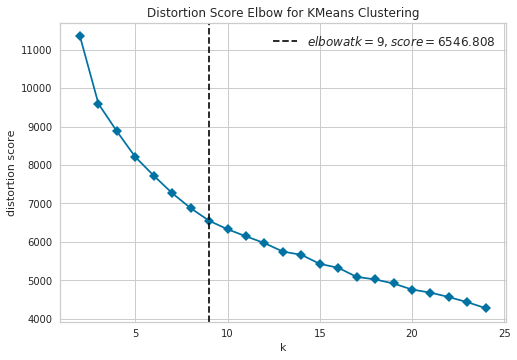

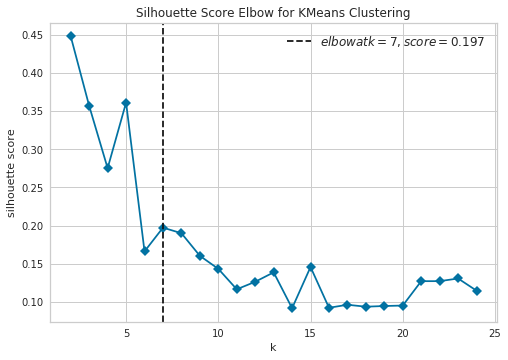

/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


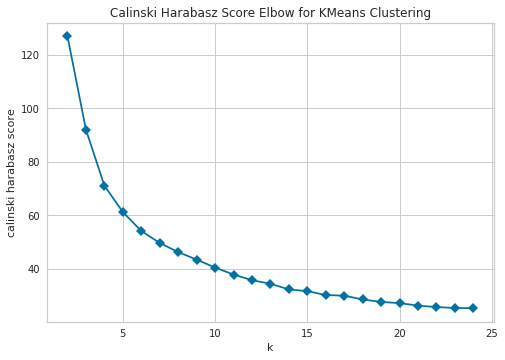

In [395]:
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import KMeans
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.datasets.loaders import load_nfl

london_grouped_clustering2 = london_grouped2.drop('Location', 1)
model = KMeans(random_state=0)
# Use the quick method and immediately show the figure
v = KElbowVisualizer(model, k=(2,25),metric="distortion",timings=False)
v.fit(london_grouped_clustering2)
v.show()
v1 = KElbowVisualizer(model, k=(2,25),metric="silhouette",timings=False)
v1.fit(london_grouped_clustering2)
v1.show()
v2 = KElbowVisualizer(model, k=(2,25),metric="calinski_harabasz",timings=False)
v2.fit(london_grouped_clustering2)
v2.show()

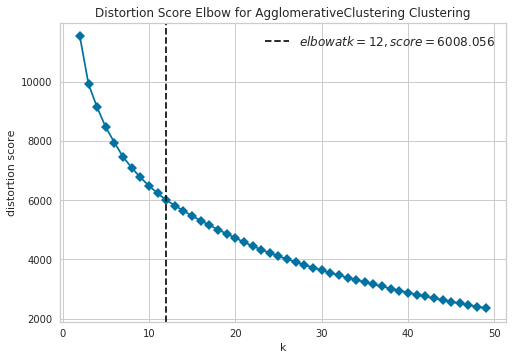

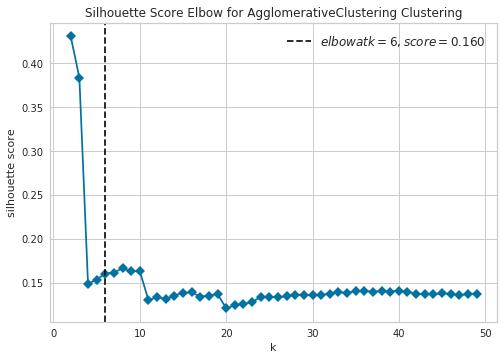

/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/law/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


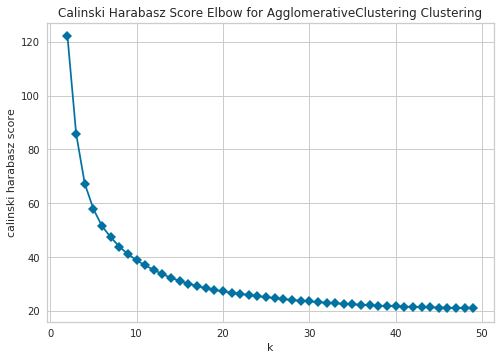

In [396]:
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import KMeans
#!conda install -c districtdatalabs yellowbrick --yes
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.datasets.loaders import load_nfl

london_grouped_clustering2 = london_grouped2.drop('Location', 1)
model = AgglomerativeClustering(linkage="ward")
# Use the quick method and immediately show the figure
v = KElbowVisualizer(model, k=(2,50),metric="distortion",timings=False)
v.fit(london_grouped_clustering2)
v.show()
v1 = KElbowVisualizer(model, k=(2,50),metric="silhouette",timings=False)
v1.fit(london_grouped_clustering2)
v1.show()
v2 = KElbowVisualizer(model, k=(2,50),metric="calinski_harabasz",timings=False)
v2.fit(london_grouped_clustering2)
v2.show()

In [345]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]



num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Location'] = london_grouped2['Location']

for ind in np.arange(london_grouped2.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(london_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head(15)


Location         1st Most Common Venue  \
0             Acton Central                _Entertainment   
1                   Aldgate             _Asian Restaurant   
2              Aldgate East             _Asian Restaurant   
3                All Saints                _Grocery Store   
4                     Angel                          _Pub   
5                   Arsenal                          _Gym   
6              Baker Street                _Entertainment   
7                  Barbican                         _Arts   
8              Barons Court           _Travel & Transport   
9            Battersea Park  _Professional & Other Places   
10  Battersea Power Station  _Professional & Other Places   
11                Bayswater             _Asian Restaurant   
12             Belsize Park                _Entertainment   
13               Bermondsey                _Grocery Store   
14            Bethnal Green                          _Bar   

     2nd Most Common Venue   3rd Most Common Venue  \
0                     _Pub          _Grocery Store   
1                     _Pub                    _Bar   
2                     _Pub       _Coffee Shop/Café   
3        _Asian Restaurant  _Outdoors & Recreation   
4        _Asian Restaurant          _Grocery Store   
5   _Outdoors & Recreation                   _Arts   
6                    _Arts       _Asian Restaurant   
7                     _Bar                    _Gym   
8                     _Gym                    _Pub   
9                     _Pub       _Asian Restaurant   
10                    _Pub     _Travel & Transport   
11           _Accomodation             _Restaurant   
12  _Outdoors & Recreation                   _Food   
13                    _Pub                   _Food   
14                    _Gym                   _Arts   

           4th Most Common Venue 5th Most Common Venue  \
0         _Outdoors & Recreation   _Travel & Transport   
1                           _Gym    _Indian Restaurant   
2                           _Bar   _Italian Restaurant   
3            _Italian Restaurant         _Accomodation   
4              _Coffee Shop/Café                 _Food   
5                          _Food   _Travel & Transport   
6                          _Food     _Coffee Shop/Café   
7   _Professional & Other Places   _Italian Restaurant   
8                          _Arts     _Coffee Shop/Café   
9                           _Bar   _Travel & Transport   
10                          _Bar       _Shop & Service   
11                _Grocery Store                  _Pub   
12           _Italian Restaurant       _Shop & Service   
13             _Coffee Shop/Café           _Restaurant   
14             _Coffee Shop/Café        _Grocery Store   

     6th Most Common Venue   7th Most Common Venue  \
0                    _Food         _Shop & Service   
1        _Coffee Shop/Café           _Accomodation   
2                     _Gym             _Restaurant   
3       _Indian Restaurant         _Shop & Service   
4          _Shop & Service                    _Gym   
5                     _Bar         _Shop & Service   
6              _Restaurant      _Indian Restaurant   
7   _Outdoors & Recreation             _Restaurant   
8            _Accomodation             _Restaurant   
9      _Italian Restaurant                   _Food   
10                   _Food                   _Arts   
11  _Outdoors & Recreation                    _Gym   
12       _Coffee Shop/Café             _Restaurant   
13     _Travel & Transport                   _Arts   
14     _Italian Restaurant  _Outdoors & Recreation   

           8th Most Common Venue   9th Most Common Venue  \
0                          _Arts       _Asian Restaurant   
1                    _Restaurant                   _Food   
2                  _Accomodation      _Indian Restaurant   
3              _Coffee Shop/Café                   _Food   
4                    _Restaurant                    _Bar   
5   _Professional & Oth

In [397]:
from sklearn.cluster import AgglomerativeClustering

# set number of clusters
kclusters = 9

london_grouped_clustering2 = london_grouped2.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(london_grouped_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 7, 7, 0, 1, 0, 1, 5, 0, 0], dtype=int32)

In [398]:
# add clustering labels
london_grouped2.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged_2 = london_data

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged_2 = london_merged_2.merge(right=london_grouped2,how="left",right_on='Location', left_on='Station')

london_merged_2.head() # check the last columns!


Station  Zone  Postcode   Latitude  Longitude  Easting  Northing  \
0  Acton Central   2.0    W3 6BH  51.508758  -0.263430   520613    180299   
1        Aldgate   1.0  EC3N 1AH  51.514342  -0.075627   533629    181246   
2   Aldgate East   1.0    E1 7PT  51.515082  -0.073001   533809    181333   
3     All Saints   2.0   E14 0EH  51.510477  -0.012625   538012    180933   
4          Angel   1.0    N1 8XB  51.532968  -0.105581   531497    183263   

   Cluster Labels       Location  _Accomodation  _Arts  _Asian Restaurant  \
0             0.0  Acton Central            0.0    0.0                0.0   
1             7.0        Aldgate            5.0    0.0                6.0   
2             7.0   Aldgate East            5.0    2.0                8.0   
3             0.0     All Saints            2.0    0.0                2.0   
4             1.0          Angel            3.0    2.0                5.0   

   _Bar  _Coffee Shop/Café  _Entertainment  _Food  _Grocery Store  _Gym  \
0   0.0                0.0             1.0    1.0             1.0   0.0   
1   6.0                7.0             0.0    5.0             0.0   3.0   
2   5.0               13.0             0.0    4.0             1.0   2.0   
3   0.0                1.0             0.0    1.0             2.0   0.0   
4   3.0               10.0             0.0   10.0             3.0   3.0   

   _Indian Restaurant  _Italian Restaurant  _Outdoors & Recreation  \
0                 0.0                  0.0                     1.0   
1                 4.0                  2.0                     0.0   
2                 2.0                  4.0                     0.0   
3                 1.0                  2.0                     2.0   
4                 1.0                  2.0                     1.0   

   _Professional & Other Places  _Pub  _Restaurant  _Shop & Service  \
0                           0.0   2.0          0.0              1.0   
1                           0.0   5.0          7.0              0.0   
2                           0.0   7.0          8.0              0.0   
3                           0.0   0.0          1.0              3.0   
4                           0.0   5.0         10.0             14.0   

   _Travel & Transport  
0                  1.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  1.0

In [399]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
london_merged_2 = london_merged_2[london_merged_2['Cluster Labels']>-1]
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
london_merged.dropna(subset=['Cluster Labels'],inplace=True)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged_2['Latitude'], london_merged_2['Longitude'], london_merged_2['Station'], london_merged_2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=300,
        popup=label,
        color=rainbow[int(cluster)-1] ,
        fill=True,
        fill_color= rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

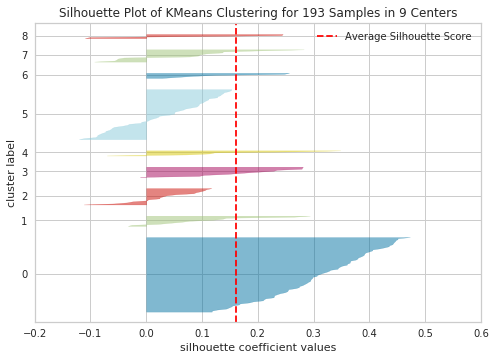

In [400]:
from yellowbrick.cluster import silhouette_visualizer


# Load a clustering dataset
model = KMeans(9,random_state=0)
v1 = silhouette_visualizer(model, london_grouped_clustering2, colors='yellowbrick')
v1.fit(london_grouped_clustering2)
v1.show()

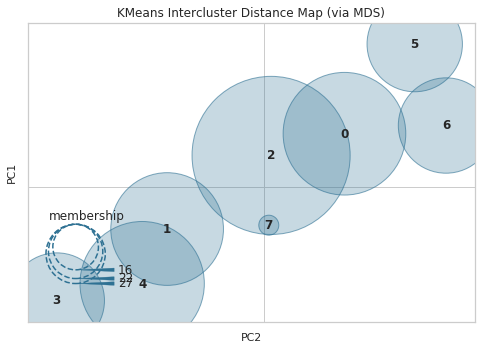

/home/law/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e25b4ad90>,
                     embedding='mds', is_fitted='auto', legend=True,
                     legend_loc='lower left', legend_size=1.5, max_size=25000,
                     min_size=400, model=None, random_state=None,
                     scoring='membership')

In [281]:
from yellowbrick.datasets import load_nfl
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import intercluster_distance


X, _ = load_nfl()
intercluster_distance(KMeans(8), london_grouped2.drop('Location', 1))

In [453]:
london_merged_2.loc[london_merged_2['Cluster Labels'] == 3]


Station  Zone  Postcode   Latitude  Longitude  Easting  \
23                Brixton   2.0   SW9 8HE  51.462737  -0.114552   531076   
40         Clapham Common   2.0   SW4 7AJ  51.461804  -0.138315   529428   
49      Dalston Kingsland   2.0    E8 2JS  51.548668  -0.076227   533487   
62             Farringdon   1.0  EC1M 6BY  51.520196  -0.104843   531585   
81            Heron Quays   2.0   E14 4JH  51.503387  -0.021954   537386   
110      Liverpool Street   1.0  EC2M 7PR  51.517598  -0.082250   533160   
115         Mansion House   1.0  EC4N 6JD  51.512092  -0.094198   532347   
161             St. Pauls   1.0  EC2V 6AA  51.514835  -0.097571   532105   
169  Tottenham Court Road   1.0   W1D 2DA  51.516211  -0.131110   529774   
182         Waterloo East   1.0   SE1 8NH  51.504169  -0.109154   531332   
186       West India Quay   2.0   E14 4ED  51.506763  -0.020582   537471   

     Northing  Cluster Labels              Location  _Accomodation  _Arts  \
23     175437             3.0               Brixton            1.0    3.0   
40     175291             3.0        Clapham Common            0.0    0.0   
49     185062             3.0     Dalston Kingsland            0.0    3.0   
62     181844             3.0            Farringdon            2.0    1.0   
81     180127             3.0           Heron Quays            1.0    0.0   
110    181596             3.0      Liverpool Street            1.0    1.0   
115    180962             3.0         Mansion House            1.0    1.0   
161    181261             3.0             St. Pauls            0.0    1.0   
169    181354             3.0  Tottenham Court Road            1.0    3.0   
182    180054             3.0         Waterloo East            1.0    2.0   
186    180505             3.0       West India Quay            0.0    2.0   

     _Asian Restaurant  _Bar  _Coffee Shop/Café  _Entertainment  _Food  \
23                 7.0   9.0                4.0             1.0   10.0   
40                 3.0   6.0                6.0             1.0    4.0   
49                 2.0   9.0                4.0             2.0    4.0   
62                 4.0   8.0                5.0             0.0    7.0   
81                 4.0   2.0                6.0             0.0   12.0   
110                6.0   4.0                3.0             0.0    6.0   
115                7.0   6.0                7.0             0.0    8.0   
161                5.0   3.0                4.0             0.0   11.0   
169                6.0   8.0                5.0             0.0    5.0   
182                5.0   5.0                6.0             0.0   10.0   
186                4.0   5.0                4.0             1.0   10.0   

     _Grocery Store  _Gym  _Indian Restaurant  _Italian Restaurant  \
23              2.0   4.0                 2.0                  5.0   
40              4.0   2.0                 1.0                  4.0   
49              2.0   1.0                 0.0                  2.0   
62              0.0   2.0                 0.0                  4.0   
81              2.0   2.0                 1.0                  4.0   
110             0.0   6.0                 0.0                  2.0   
115             1.0   3.0                 1.0                  3.0   
161             2.0   2.0                 0.0                  6.0   
169             0.0   1.0                 0.0                  3.0   
182             0.0   2.0                 0.0                  2.0   
186             0.0   3.0                 1.0                  2.0   

     _Outdoors & Recreation  _Professional & Other Places  _Pub  _Restaurant  \
23                      1.0                           1.0   1.0         25.0   
40                      1.0                           0.0   3.0         21.0   
49                      2.0                           0.0   1.0         17.0   
62                      2.0                           0.0   6.0         16.0   
81                      4.0                       

In [ ]:
london_merged_2.loc[london_merged_2['Station'] == 'Hyde Park']

In [ ]:
london_merged_2.loc[london_merged_2['Station'] == 'Hyde Park']

/home/law/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


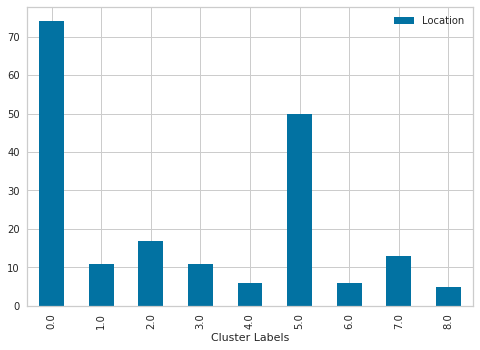

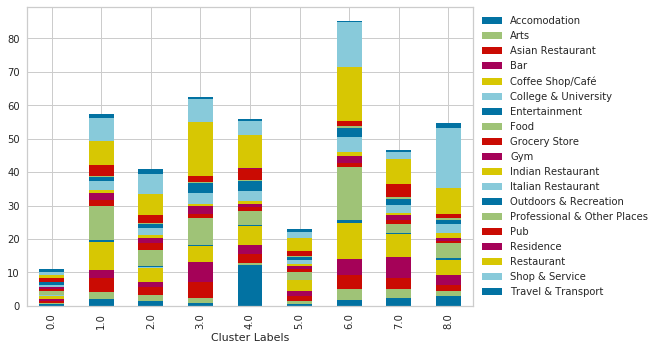

In [448]:
right = london_merged_2[['Location','Cluster Labels']]
right['one'] = 1
#x2 = london_merged_2[['Station','Cluster_Labels','Venue Category','Venue Type']]
df_graph = london_venues_cat2.merge(right=right,left_on='Location',right_on="Location",how="left")
df_graph.head()

g1 = df_graph.pivot_table(index=["Cluster Labels"],columns=['Venue Type'],values='one',aggfunc=len,fill_value=0)
g2 = df_graph.pivot_table(index=["Cluster Labels"],values='Location',aggfunc=lambda x: len(x.unique()),fill_value=0)
g3 = g1.divide(g2['Location'],axis=0)
g2.plot.bar()
g3.plot.bar(stacked=True,).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [409]:
df_graph.columns

Index(['Location', 'Location Latitude', 'Location Longitude', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Venue Type',
       'original', 'Cluster Labels'],
      dtype='object')